In [3]:
# Import libraries.
using Turing, StatsPlots, Random, Memoization, StatsBase  

In [10]:
using ProgressMeter


## The model of agent as universal Probalistic Model
### gets some parmeters:
<ul>
    <li> opponent agent - representation of our belief on the opponent model (Turing.jl model)
    <li> my history - list of all moves this player done (At this point unused)
    <li> opponent history - list of all moves the opponent done, used to estimate a prior on the moves
    <li> depth - the depth we want the agent will dive modeling the mind of opponent agent
</ul>        

In [4]:
N = 10000
INFALG = IS()
PRIOR_POLICY = [1,1,1]
PDIRAC = 0.95

0.95

In [5]:
function winning(opp_move)
    best_moves = Dict(1 => 2, 2 => 3, 3 => 1)
    move = best_moves[opp_move]
    return move
end

winning (generic function with 1 method)

In [6]:
@model function agent(opponent_chn, opponent_history, opp_prior_policy = [1,1,1], depth = 1)
    beta_opp ~ Dirichlet(opp_prior_policy) #prior
    if depth == 0
        for i in 1:length(opponent_history)
            opponent_history[i] ~ Categorical(beta_opp) # observe
        end
        next_opp_move ~ Categorical(beta_opp) # sample
    end
    if depth > 0
        weights = exp.(opponent_chn[:lp][:, 1])
        idx ~ Categorical(weights/sum(weights))
        opp_move_sample = opponent_chn[:my_move][idx, 1]
        
        # init alternative way to Dirac distribution
        complete_p_dirac = (1 - PDIRAC) / 2
        phi = fill(complete_p_dirac, 3)
        phi[convert(Int, opp_move_sample)] = PDIRAC
        
        next_opp_move ~ Categorical(phi) # observe
    end
    winning_move = winning(next_opp_move)
    
    # init alternative way to Dirac distribution
    complete_p_dirac = (1 - PDIRAC) / 2
    phi = fill(complete_p_dirac, 3)
    phi[convert(Int,winning_move)] = PDIRAC
    
    my_move ~ Categorical(phi) # Dirac(next_opp_move) / observe(next_opponent_move, infered_opponent_move)
end

agent (generic function with 3 methods)

In [39]:
# Plot the results
function plotChn(chn)
    histogram(chn[:my_move], weights=exp.(chn[:lp]), normalize=:probability)
end

plotChn (generic function with 1 method)

In [31]:
function run_two_agents_theory_of_mind(my_model, other_model, opponent_prior, my_prior , opponent_history, my_history, depth)
    second_chn_i = []
    first_chn_i = []
    @showprogress for i in 0:depth
        first_chn_i = sample(my_model(second_chn_i, my_history, my_prior, i),  INFALG, N , progress = false)
        second_chn_i = sample(other_model(first_chn_i, opponent_history, opponent_prior, i), INFALG, N , progress = false)
    end
    return second_chn_i
end

run_two_agents_theory_of_mind (generic function with 2 methods)

## Depth 0

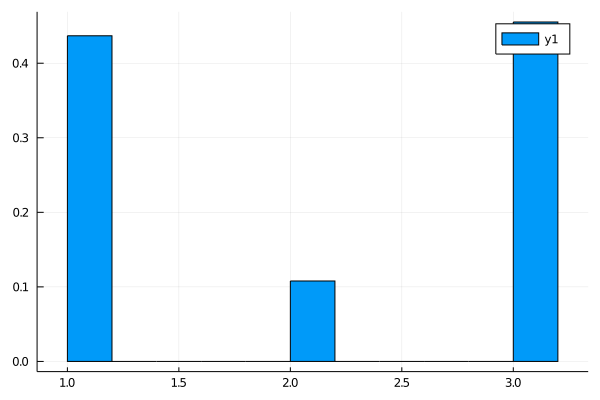

In [40]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,1,1], [], [], 0))

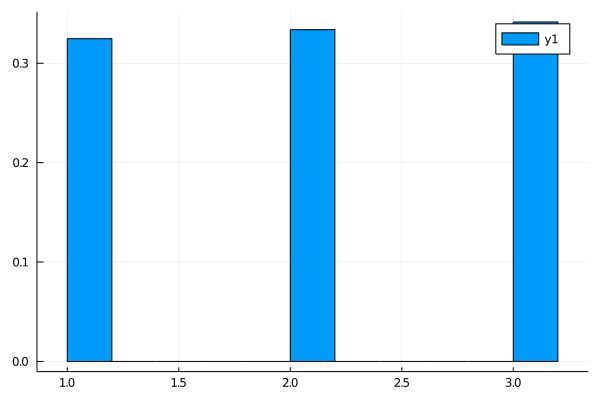

In [41]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 0))

## Depth 3

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


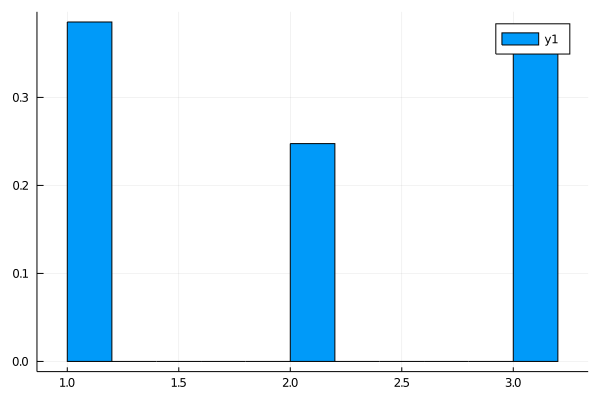

In [42]:
plotChn(run_two_agents_theory_of_mind(agent, agent,[1,5,5], [1,1,1], [], [], 3))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


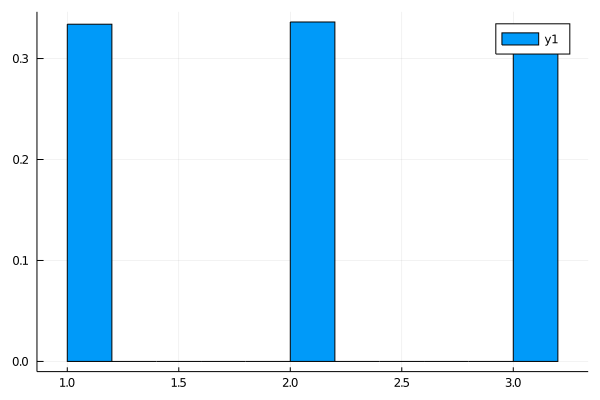

In [43]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 3))

## Depth 10

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


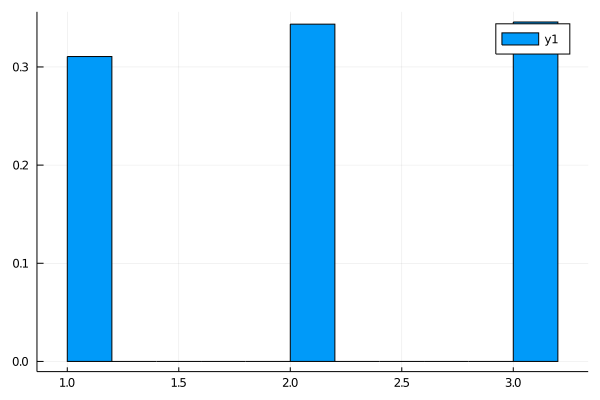

In [49]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,5,5], [1,1,1], [], [], 10))

Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


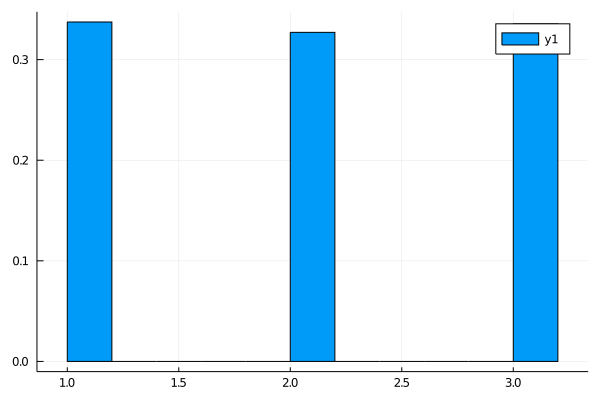

In [45]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 10))

## Depth 20

Progress: 100%|█████████████████████████████████████████| Time: 0:02:19


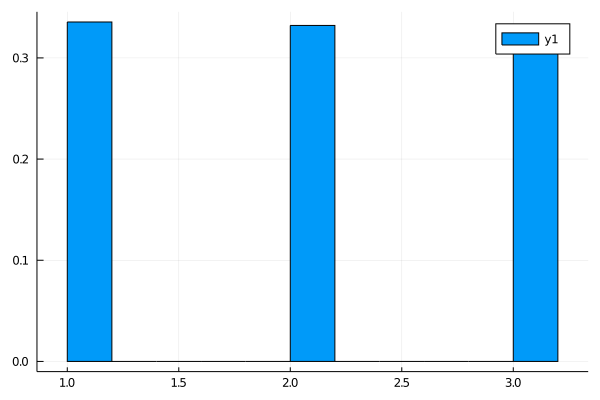

In [50]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,1,1], [], [], 20))

Progress: 100%|█████████████████████████████████████████| Time: 0:02:17


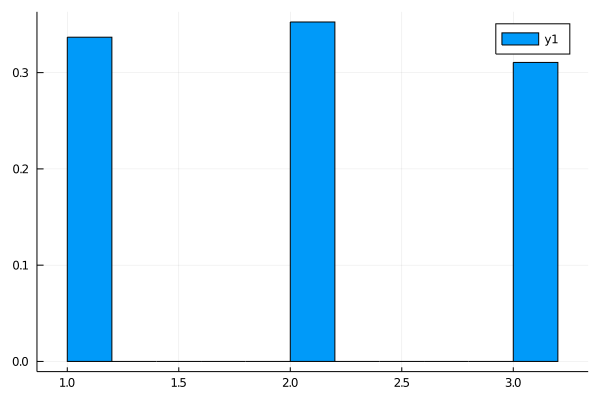

In [52]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 20))

# Simulations

In [21]:
function sample_move(chn)
    weights = exp.(chn[:lp][:, 1])
    weights = Weights(weights/sum(weights))
    idx = sample(collect(1:length(weights)), weights)
    move_sample = chn[:my_move][idx, 1]
    return move_sample
end

sample_move (generic function with 1 method)

In [22]:
function move(agent, other_agent, other_agent_history, my_history, other_player_prior, my_depth=1)
    other_agent_history = length(other_agent_history) > 0 ? other_agent_history : [1]
    other_agent_history = Array{Int}(other_agent_history)
    my_history = length(my_history) > 0 ? my_history : [1]
    my_history = Array{Int}(my_history)
    m = agent(other_agent, other_agent_history, other_player_prior, my_depth)
    chain = run_two_agents_theory_of_mind(agent, other_agent, other_player_prior, [1,1,1] , other_agent_history, my_history, my_depth)
    return sample_move(chain)
end

move (generic function with 2 methods)

In [23]:
function game(first_player_depth = 1, second_player_depth = 1, first_player_prior_policy = [1,1,1] , second_player_prior_policy = [1, 1, 1])
    first_player = agent
    second_player = agent
    num_of_simulations = 50
    first_player_history = []
    second_player_history = []
    
    @showprogress for i in 1:num_of_simulations
        m1 = move(first_player, second_player, second_player_history, first_player_history, second_player_prior_policy, first_player_depth)
        push!(first_player_history, m1)
        m2 = move(second_player, first_player, first_player_history, second_player_history, first_player_prior_policy, second_player_depth)
        push!(second_player_history, m2)
    end
    return first_player_history, second_player_history
 end

game (generic function with 5 methods)

In [24]:
function score(history)
    first_player_history, second_player_history = history
    first_wins = 0
    ties = 0
    second_wins = 0
    wins = Dict(1 => 3, 2 => 1, 3 => 2)
    for i in 1:length(first_player_history)
        if wins[first_player_history[i]] == second_player_history[i]
            second_wins += 1
        elseif wins[second_player_history[i]] == first_player_history[i]
            first_wins += 1
        else
            ties += 1
        end
    end
    return first_wins, ties, second_wins
end

score (generic function with 1 method)

In [65]:
function accumulated_score(history)
    first_player_history, second_player_history = history
    first_wins, ties, second_wins = 0, 0, 0
    acc_result = []
    wins = Dict(1 => 3, 2 => 1, 3 => 2)
    for i in 1:length(first_player_history)
        if wins[first_player_history[i]] == second_player_history[i]
            second_wins += 1
        elseif wins[second_player_history[i]] == first_player_history[i]
            first_wins += 1
        else
            ties += 1
        end
        push!(acc_result, [first_wins, ties, second_wins])
    end
    return acc_result
end

accumulated_score (generic function with 1 method)

In [75]:
function plot_accumulated_score(acc_result)
    n = length(acc_result)
    acc_result = transpose(reduce(hcat, acc_result))
    plot(1:n, acc_result)
end

plot_accumulated_score (generic function with 1 method)

In [67]:
function display_score(score)
    num_of_wins_first, num_of_ties, num_of_wins_second = score
    println("first player won: $num_of_wins_first")
    println("second player won: $num_of_wins_second") 
    println("ties: $num_of_ties") 
end

display_score (generic function with 1 method)

In [26]:
display_score(score(game(0, 0)))

Progress: 100%|█████████████████████████████████████████| Time: 0:04:36


first player won: 17
second player won: 15
ties: 18


In [68]:
acc_score = accumulated_score(game(0, 0))

Progress: 100%|█████████████████████████████████████████| Time: 0:06:10


50-element Array{Any,1}:
 [0, 1, 0]
 [1, 1, 0]
 [2, 1, 0]
 [2, 1, 1]
 [2, 2, 1]
 [3, 2, 1]
 [3, 2, 2]
 [3, 2, 3]
 [4, 2, 3]
 [5, 2, 3]
 [5, 3, 3]
 [5, 4, 3]
 [5, 5, 3]
 ⋮
 [15, 11, 13]
 [15, 11, 14]
 [16, 11, 14]
 [16, 11, 15]
 [16, 12, 15]
 [16, 12, 16]
 [16, 13, 16]
 [17, 13, 16]
 [18, 13, 16]
 [18, 14, 16]
 [18, 15, 16]
 [18, 16, 16]

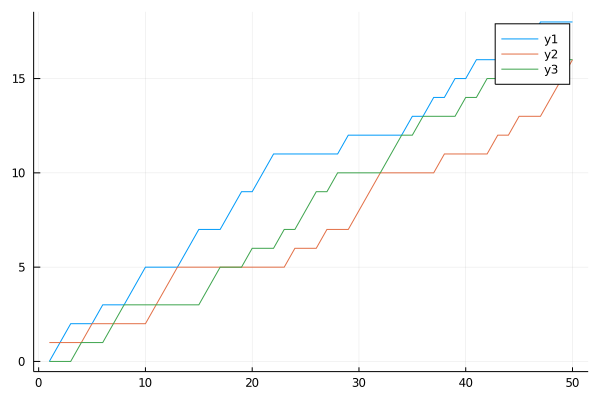

In [76]:
plot_accumulated_score(acc_score)

In [ ]:
plot_accumulated_score(accumulated_score(game(0, 0)))

Progress:  32%|██████████████                           |  ETA: 0:02:20

In [ ]:
plot_accumulated_score(accumulated_score(game(0, 0)))

In [ ]:
plot_accumulated_score(accumulated_score(game(0, 0, [1,1,1] , [5, 10, 1])))

In [ ]:
plot_accumulated_score(accumulated_score(game(0, 0, [1,1,1] ,  [5, 10, 1])))

In [ ]:
plot_accumulated_score(accumulated_score(game(0, 0, [5, 10, 1] ,  [1,1,1])))

In [ ]:
plot_accumulated_score(accumulated_score(game(0, 0, [5, 10, 1] , [1,1,1])))

In [ ]:
plot_accumulated_score(accumulated_score(game(0, 3)))

In [ ]:
plot_accumulated_score(accumulated_score(game(0, 3)))

In [ ]:
plot_accumulated_score(accumulated_score(game(0, 3, [1,1,1] , [5, 10, 1])))

In [50]:
display_score(score(game(0, 3, [1,1,1] , [5, 10, 1])))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 

first player won: 19
second player won: 17
ties: 14


In [51]:
display_score(score(game(0, 3, [5, 10, 1] ,  [1,1,1])))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 

first player won: 13
second player won: 20
ties: 17


In [52]:
display_score(score(game(0, 3, [5, 10, 1] , [1,1,1])))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 

first player won: 19
second player won: 16
ties: 15


In [26]:
display_score(score(game(3, 0)))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 

first player won: 21
second player won: 14
ties: 15


In [27]:
display_score(score(game(3, 0)))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 

first player won: 17
second player won: 19
ties: 14


In [53]:
display_score(score(game(3, 0, [5, 10, 1] , [1,1,1])))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 

first player won: 13
second player won: 23
ties: 14


In [54]:
display_score(score(game(3, 0, [5, 10, 1] ,  [1,1,1])))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 

first player won: 26
second player won: 13
ties: 11


In [56]:
display_score(score(game(3, 0, [1,1,1] , [5, 10, 1])))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 

first player won: 19
second player won: 15
ties: 16


In [57]:
display_score(score(game(3, 0,  [1,1,1] ,  [5, 10, 1])))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 

first player won: 24
second player won: 16
ties: 10


In [29]:
display_score(score(game(3, 3)))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 

first player won: 14
second player won: 19
ties: 17


In [30]:
display_score(score(game(3, 3)))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 

first player won: 21
second player won: 15
ties: 14


In [31]:
display_score(score(game(5, 0)))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 

first player won: 22
second player won: 13
ties: 15


In [32]:
display_score(score(game(5, 0)))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 

first player won: 18
second player won: 18
ties: 14
